__Student info:__

- Student name: Thomas Brown
- Student pace: Full Time
- Scheduled project review date/time: TBD
- Instructor name: Abhineet Kulkarni
- Blog post URL: TBD

__Use Case:__<br><br>
The purpose of this project is to start building a neural network model that can determine the sentiment of financial news headlines.  The users of this model would be investment firms who want to keep track of the market sentiment of a set of various products, companies, or industries.  <br><br>
With proper web scraping and feeding of new headlines, a firm would be able to keep track of various topics to make better informed investing decisions.  For example, one could feasibly keep track of terms that are rising rapidly in terms of positive sentiment in order to invest in them.<br><br>
The data is collected from Kaggle through this [link](https://www.kaggle.com/ankurzing/sentiment-analysis-for-financial-news).  It's a collection of 4,837 unique news headlines from various financial news sources. 

## Importing Libraries:

In [1]:
import pandas as pd
import numpy as np

# Scikit-Learn:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn import svm
from sklearn import tree
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder


# Keras:
import keras
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Conv1D, MaxPool1D, Flatten, Dropout
from keras.utils import to_categorical
from keras.layers import Embedding, LSTM, Dense, Dropout


# NLTK - Stopwords:
import nltk
from nltk.corpus import stopwords
import string
from nltk import word_tokenize, FreqDist
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet


# Sampling:
from imblearn.over_sampling import SMOTE, ADASYN

# XGBoost:
import xgboost as xgb

# Plots and Graphs:
from wordcloud import WordCloud
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
import plotly.express as px
import scikitplot as skplt 
%matplotlib inline

# Other:
from collections import Counter
import warnings
warnings.filterwarnings('ignore')
# So we can see the entire column:
pd.set_option('display.max_colwidth', -1)

Using TensorFlow backend.
/Users/Thomas/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


# Importing Data:

In [2]:
df = pd.read_csv('all-data.csv', names = ['Sentiment', 'Headline'], 
                 encoding='latin-1')
df = df.sample(frac=1).reset_index(drop=True) # Shuffling the data in case there's an ordering bias
display(df.head())
print("Shape:", df.shape, "\n\n")
print(df.info())

,Sentiment,Headline
0,positive,"This new representation extends Comptel 's global presence to a total of 18 countries , serving over 250 customers in over 80 countries worldwide ."
1,positive,"The disposal of Autotank will also strengthen Aspo 's capital structure , '' commented Gustav Nyberg , CEO of Aspo ."
2,neutral,The value of the orders is over EUR 25mn .
3,negative,"According to Aktia Asset Management , Finnish analysts ' forecasts for 2009 are still too high ."
4,neutral,"Currently , the company uses eight similar reach stackers and four empty container handlers by Konecranes ."


Shape: (4846, 2) 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4846 entries, 0 to 4845
Data columns (total 2 columns):
Sentiment    4846 non-null object
Headline     4846 non-null object
dtypes: object(2)
memory usage: 75.8+ KB
None


In [3]:
# Let's take a look at the number of instances of each sentiment:
df.Sentiment.value_counts()
# Not too many negatives.  This may prove to be an issue later on, but for now, let's keep moving.

neutral     2879
positive    1363
negative    604 
Name: Sentiment, dtype: int64

# Cleaning Data:

First, the labels need to be changed to numerical values in order to go through the neural network later on.

- 0 is Negative
- 1 is Neutral
- 2 is Positive

In [4]:
# TERNARY
# Encoding Sentiment
lb_make = LabelEncoder()
df["Sentiment"] = lb_make.fit_transform(df["Sentiment"])
df.head()

,Sentiment,Headline
0,2,"This new representation extends Comptel 's global presence to a total of 18 countries , serving over 250 customers in over 80 countries worldwide ."
1,2,"The disposal of Autotank will also strengthen Aspo 's capital structure , '' commented Gustav Nyberg , CEO of Aspo ."
2,1,The value of the orders is over EUR 25mn .
3,0,"According to Aktia Asset Management , Finnish analysts ' forecasts for 2009 are still too high ."
4,1,"Currently , the company uses eight similar reach stackers and four empty container handlers by Konecranes ."


In [5]:
# BINARY
#df['Sentiment'] = df['Sentiment'].map(lambda x: 1 if x == 'positive' else 0)
#df.head()

## Stopwords:

Next, we can remove all the 'stopwords' that can clog up the system later on.  The punctuation will get filtered out later.

In [6]:
stop = set(stopwords.words('english'))
stop.add("'s")
def remove_stopwords(text):
    text = [word.lower() for word in text.split() if word.lower() not in stop]
    return " ".join(text)

df['Headline'] = df['Headline'].map(remove_stopwords)

In [7]:
df.head()

,Sentiment,Headline
0,2,"new representation extends comptel global presence total 18 countries , serving 250 customers 80 countries worldwide ."
1,2,"disposal autotank also strengthen aspo capital structure , '' commented gustav nyberg , ceo aspo ."
2,1,value orders eur 25mn .
3,0,"according aktia asset management , finnish analysts ' forecasts 2009 still high ."
4,1,"currently , company uses eight similar reach stackers four empty container handlers konecranes ."


## Lemmatization:

In [8]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [9]:
wordnet_lemmatizer = WordNetLemmatizer()

def lemmatize(text):
    text = [wordnet_lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in text.split()]
    return " ".join(text)

df['Headline'] = df['Headline'].map(lemmatize)

In [10]:
# Still looking good
df.head()

,Sentiment,Headline
0,2,"new representation extends comptel global presence total 18 country , serve 250 customer 80 country worldwide ."
1,2,"disposal autotank also strengthen aspo capital structure , '' comment gustav nyberg , ceo aspo ."
2,1,value order eur 25mn .
3,0,"accord aktia asset management , finnish analyst ' forecast 2009 still high ."
4,1,"currently , company us eight similar reach stacker four empty container handler konecranes ."


# EDA:

Let's explore some word clouds to see the most commonly occurring words for each label.

In [11]:
# Separating out the categories
pos = df.Headline[df.Sentiment[df.Sentiment== 2].index]
neg = df.Headline[df.Sentiment[df.Sentiment== 0].index]
neutral = df.Headline[df.Sentiment[df.Sentiment== 1].index]

In [12]:
 def wordcloud(dataset):
    plt.figure(figsize = (18,24)) # Text Reviews with positive Ratings
    wordcloud = WordCloud(min_font_size = 3,  max_words = 2500 , width = 1200 , height = 800).generate(" ".join(dataset))
    plt.imshow(wordcloud,interpolation = 'bilinear')
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show();

def show_wordclouds():
    print ('Positive Sentiment Wordcloud:')
    wordcloud(pos)
    ###
    print ('Neutral Sentiment Wordcloud:')
    wordcloud(neutral)
    ###
    print ('Negative Sentiment Wordcloud:')
    wordcloud(neutral)
    ###
    

In [13]:
# Showing Word Clounds
#show_wordclouds()

Not too much useful information here.  There are some more words we can clean, but I would like to stay on the conservative side for now.

# Additional Cleaning:

As we saw above, there are a few words that are quite common that occur in all 3 labels.  We'll add this to these to the stop word list and run the headlines through the filter again:
- 'finnish'
- 'say'
- 'company'
I'm leaving in 'eur' for now as it doesn't appear heavily in the 'Neutral' category.  This may help later on.  Depending on how the neural network performs later, I may or may not activate the following cells.

In [14]:
# Taking out a few more stop words:
stop.add("finnish")
stop.add("say")
stop.add("company")

df['Headline'] = df['Headline'].map(remove_stopwords)

In [15]:
# Starting to feel a little like caveman speak, but hopefully this will be easier for the model to read!
df.head()

,Sentiment,Headline
0,2,"new representation extends comptel global presence total 18 country , serve 250 customer 80 country worldwide ."
1,2,"disposal autotank also strengthen aspo capital structure , '' comment gustav nyberg , ceo aspo ."
2,1,value order eur 25mn .
3,0,"accord aktia asset management , analyst ' forecast 2009 still high ."
4,1,"currently , us eight similar reach stacker four empty container handler konecranes ."


In [16]:
pos = df.Headline[df.Sentiment[df.Sentiment== 2].index]
neg = df.Headline[df.Sentiment[df.Sentiment== 0].index]
neutral = df.Headline[df.Sentiment[df.Sentiment== 1].index]

In [17]:
# Showing Word Clounds with additional words removed
#show_wordclouds()

# Counter:

In [18]:
from collections import Counter

In [19]:
def counter_word(text):
    count = Counter()
    for i in text.values:
        for word in i.split():
            count[word] += 1
    return count

In [20]:
text = df.Headline
counter = counter_word(text)

In [21]:
len(counter)

10094

In [22]:
counter

Counter({'new': 269,
         'representation': 1,
         'extends': 4,
         'comptel': 17,
         'global': 69,
         'presence': 14,
         'total': 250,
         '18': 28,
         'country': 75,
         ',': 4662,
         'serve': 24,
         '250': 9,
         'customer': 139,
         '80': 19,
         'worldwide': 15,
         '.': 4780,
         'disposal': 4,
         'autotank': 2,
         'also': 224,
         'strengthen': 29,
         'aspo': 30,
         'capital': 111,
         'structure': 40,
         "''": 217,
         'comment': 18,
         'gustav': 1,
         'nyberg': 4,
         'ceo': 78,
         'value': 112,
         'order': 150,
         'eur': 1015,
         '25mn': 4,
         'accord': 123,
         'aktia': 11,
         'asset': 32,
         'management': 88,
         'analyst': 30,
         "'": 116,
         'forecast': 22,
         '2009': 297,
         'still': 13,
         'high': 65,
         'currently': 36,
         'us': 8,

In [23]:
num_words = len(counter)

# Train/Test Split:

In [24]:
# Generating the lists of headlines and labels
headlines = []
labels = []

for row in range(len(df)):
    headlines.append(df['Headline'][row])
    labels.append(df['Sentiment'][row])

In [25]:
# Setting the training ratio
training_size = int(df.shape[0] * .8) # Out of 4846

In [26]:
# Train Test Split:
training_headlines = headlines[0:training_size]
testing_headlines = headlines[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [27]:
# Looks good
display(training_headlines[:3])
display(training_labels[:3])

['new representation extends comptel global presence total 18 country , serve 250 customer 80 country worldwide .',
 "disposal autotank also strengthen aspo capital structure , '' comment gustav nyberg , ceo aspo .",
 'value order eur 25mn .']

[2, 2, 1]

# Tokenization:

In [28]:
vocab_size = len(counter) 
embedding_dim = 16
max_length = 50
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

In [29]:

# Initializing the fitting the tokenizer:
tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_tok)
tokenizer.fit_on_texts(training_headlines)
# Initializing the Word Index:
word_index = tokenizer.word_index
# Padding and Sequencing the Training Set:
training_sequences = tokenizer.texts_to_sequences(training_headlines)
training_padded = pad_sequences(training_sequences, maxlen = max_length,
                               padding = padding_type, 
                               truncating = trunc_type)
# Padding and Sequencing the Testing Set:
testing_sequences = tokenizer.texts_to_sequences(testing_headlines)
testing_padded = pad_sequences(testing_sequences, maxlen = max_length, 
                               padding = padding_type, 
                               truncating = trunc_type)


In [30]:
# Switch to Numpy Array
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [31]:
# Example of what's happening under the hood:
print ('Padded and Tokenized Headline:\n', training_padded[3])
print ('\nThe actual headline:\n', df.Headline[3])
print ('\nLabel:\n', training_labels[3])

Padded and Tokenized Headline:
 [  68 1007  432  101  417   83  579   22 1008  126    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]

The actual headline:
 accord aktia asset management , analyst ' forecast 2009 still high .

Label:
 0


## One Hot Encoding Labels

In [32]:
# One Hot Encoding:
from keras.utils import to_categorical
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
training_labels = to_categorical(training_labels)
testing_labels = to_categorical(testing_labels)
training_labels.shape, testing_labels.shape

((3876, 3), (970, 3))

# TEST NEURAL NETWORK - LSTM:

In [33]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.initializers import Constant
from keras.optimizers import Adam

In [35]:
'''
model = Sequential()

model.add(Embedding(num_words, 32, input_length = max_length))
model.add(LSTM(64, dropout = 0.1))
model.add(layers.Dense(3, activation='softmax'))

optimizer = 'Adam'

model.compile(loss = 'categorical_crossentropy', optimizer = optimizer,
             metrics = ['accuracy'])
'''

"\nmodel = Sequential()\n\nmodel.add(Embedding(num_words, 32, input_length = max_length))\nmodel.add(LSTM(64, dropout = 0.1))\nmodel.add(layers.Dense(3, activation='softmax'))\n\noptimizer = 'Adam'\n\nmodel.compile(loss = 'categorical_crossentropy', optimizer = optimizer,\n             metrics = ['accuracy'])\n"

In [ ]:
#model.summary()

In [ ]:
# history = model.fit(training_padded, training_labels, epochs = 3,
#                   validation_data = (testing_padded, testing_labels))

In [ ]:
#plot_graphs(history, "acc")
#plot_graphs(history, "loss")

## Taking a Look at Inputs:

In [36]:
# So far looks good:
n = 0

display(training_headlines[n])
print('-----------------')
display(training_padded[n])
print('-----------------')
display(training_labels[n])
print('-----------------')

display(testing_headlines[n])
print('-----------------')
display(testing_padded[n])
print('-----------------')
display(testing_labels[n])
print('-----------------')


'new representation extends comptel global presence total 18 country , serve 250 customer 80 country worldwide .'

-----------------


array([  25, 3708, 1783,  767,  191,  861,   32,  206,  125,  611, 1006,
         62,  455,  125,  718,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0], dtype=int32)

-----------------


array([0., 0., 1.], dtype=float32)

-----------------


'mr. doring eaton since 1989 act business unit manager eaton power control business unit since january 2007 .'

-----------------


array([ 439, 7292,    1,  339,    1,  730,   20,   66,  617,    1,  271,
        278,   20,   66,  339,  105,   26,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0], dtype=int32)

-----------------


array([0., 1., 0.], dtype=float32)

-----------------


# Neural Network:

In [37]:
# First let's define the functions for model evaluation
def model_eval(history):
    pd.DataFrame(history.history).plot(figsize = (8,5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  

Now it's time to build a baseline neural network:

In [ ]:
## TEST ZONE

In [38]:
from keras import layers
maxlen = 50
embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
#model.summary()

In [39]:
num_epochs = 15
history = model.fit(training_padded, training_labels, 
                    epochs=num_epochs, 
                    validation_data=(testing_padded, testing_labels),
                    batch_size = 32,
                    verbose= 1)

Train on 3876 samples, validate on 970 samples
Epoch 1/15
3876/3876 [==============================] - 1s 338us/step - loss: 0.9002 - acc: 0.6009 - val_loss: 0.8309 - val_acc: 0.6268
Epoch 2/15
3876/3876 [==============================] - 1s 228us/step - loss: 0.6885 - acc: 0.6963 - val_loss: 0.7097 - val_acc: 0.6814
Epoch 3/15
3876/3876 [==============================] - 1s 249us/step - loss: 0.4394 - acc: 0.8109 - val_loss: 0.7295 - val_acc: 0.6897
Epoch 4/15
3876/3876 [==============================] - 1s 228us/step - loss: 0.3051 - acc: 0.8617 - val_loss: 0.7817 - val_acc: 0.6845
Epoch 5/15
3876/3876 [==============================] - 1s 227us/step - loss: 0.2261 - acc: 0.9089 - val_loss: 0.7895 - val_acc: 0.6876
Epoch 6/15
3876/3876 [==============================] - 1s 224us/step - loss: 0.1266 - acc: 0.9665 - val_loss: 0.9086 - val_acc: 0.6825
Epoch 7/15
3876/3876 [==============================] - 1s 221us/step - loss: 0.0582 - acc: 0.9910 - val_loss: 0.9047 - val_acc: 0.6969
E

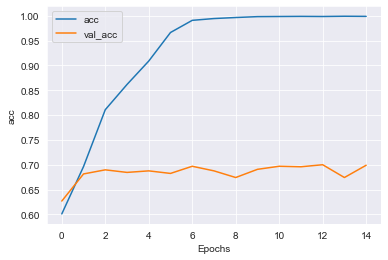

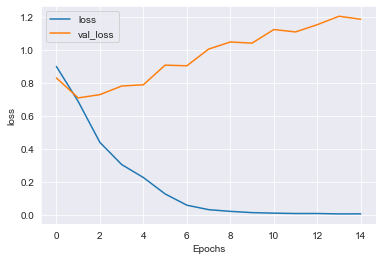

In [40]:
plot_graphs(history, "acc")
plot_graphs(history, "loss")

In [ ]:
## End TEST ZONE 

## Model # 1:

In [41]:
model = keras.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    keras.layers.GlobalAveragePooling1D(),
    keras.layers.Dense(35, activation='relu'),
    keras.layers.Dropout(0.2), # Optional Regularization
    keras.layers.Dense(20, activation='relu'), # Optional second hidden layer
    keras.layers.Dense(3, activation='softmax')])

#model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy']) # Orig code
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy']) # New code for 3 categories

In [42]:
#model.summary()

In [43]:
num_epochs = 15
history = model.fit(training_padded, training_labels, 
                    epochs=num_epochs, 
                    validation_data=(testing_padded, testing_labels), 
                    verbose= 2)

Train on 3876 samples, validate on 970 samples
Epoch 1/15
 - 1s - loss: 1.0233 - acc: 0.5826 - val_loss: 0.9767 - val_acc: 0.5835
Epoch 2/15
 - 1s - loss: 0.9519 - acc: 0.5967 - val_loss: 0.9461 - val_acc: 0.5835
Epoch 3/15
 - 1s - loss: 0.9338 - acc: 0.5967 - val_loss: 0.9370 - val_acc: 0.5835
Epoch 4/15
 - 1s - loss: 0.9275 - acc: 0.5967 - val_loss: 0.9338 - val_acc: 0.5835
Epoch 5/15
 - 1s - loss: 0.9256 - acc: 0.5967 - val_loss: 0.9321 - val_acc: 0.5835
Epoch 6/15
 - 1s - loss: 0.9239 - acc: 0.5967 - val_loss: 0.9308 - val_acc: 0.5835
Epoch 7/15
 - 1s - loss: 0.9239 - acc: 0.5967 - val_loss: 0.9305 - val_acc: 0.5835
Epoch 8/15
 - 1s - loss: 0.9236 - acc: 0.5967 - val_loss: 0.9301 - val_acc: 0.5835
Epoch 9/15
 - 1s - loss: 0.9240 - acc: 0.5967 - val_loss: 0.9299 - val_acc: 0.5835
Epoch 10/15
 - 1s - loss: 0.9239 - acc: 0.5967 - val_loss: 0.9301 - val_acc: 0.5835
Epoch 11/15
 - 1s - loss: 0.9241 - acc: 0.5967 - val_loss: 0.9295 - val_acc: 0.5835
Epoch 12/15
 - 1s - loss: 0.9236 - acc

### Model Evaluation:

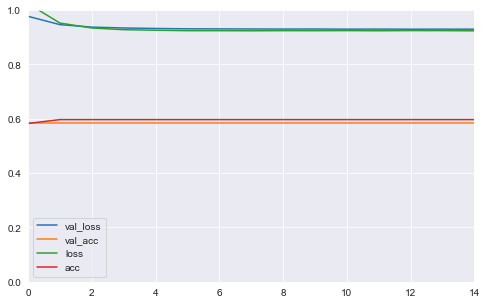

In [44]:
model_eval(history)

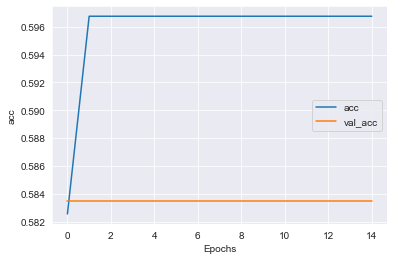

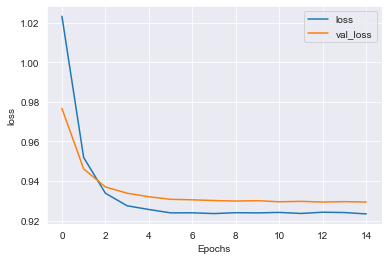

In [45]:
plot_graphs(history, "acc")
plot_graphs(history, "loss")

## Neural Network with Transfer Learning:

### Model Evaluation:

# Other:

In [ ]:
print break_

In [ ]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_sentence(training_padded[0]))
print(training_headlines[2])
print(labels[2])

In [ ]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

In [ ]:
'''
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()
'''

In [ ]:
# Sort of working!
sentence = ["stocks rise rapidly for Tesla", "Apple factory burns to the ground"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, 
                       padding=padding_type, 
                       truncating=trunc_type)
print(model.predict(padded))

# Further Work:

In the future, I'd like to complete the following analysis:
- A web application that collects and analyzes headlines from various financial news sources.
- Other neural network architecture types.
- New types of sentiment analysis, such as breaking news vs an opinion piece on an older issue.

# Conclusion: